# Capstone Project: Classifying clinically actionable genetic mutations

***

## Notebook 4: Alternative Model

This notebook contains code to find an alternative model, if possible, based on static word embeddings that outperforms the baseline model in terms of the balanced accuracy, balanced F1 and micro-average AUC scores.

<div class="alert alert-block alert-info">
Note: This notebook takes approx. 5 h 1 min to run on a PC with an Intel i7-8565U CPU, 16GB of RAM and Windows 10 operating system.
</div>

### Contents

- [Importing of Libraries](#Importing-of-Libraries)
- [Data Import](#Data-Import)
- [Preparation for Modelling](#Preparation-for-Modelling)
- [Exploring static word embeddings](#Exploring-static-word-embeddings)
    - [Loading of pre-trained word embeddings based on GloVe](#Loading-of-pre-trained-word-embeddings-based-on-GloVe)
    - [Creation of Word2Vec word embeddings based on training dataset vocabulary](#Creation-of-Word2Vec-word-embeddings-based-on-training-dataset-vocabulary)
    - [Finding the best combination of word embeddings and vectorizer](#Finding-the-best-combination-of-word-embeddings-and-vectorizer)
- [Creation of (Inner) Training and Validation Datasets](#Creation-of-(Inner)-Training-and-Validation-Datasets)
- [Combining word embeddings with dummy columns](#Combining-word-embeddings-with-dummy-columns)
- [Handling of imbalanced classes](#Handling-of-imbalanced-classes)
- [Scaling the data for PCA](#Scaling-the-data-for-PCA)
- [Dimensionality reduction using PCA](#Dimensionality-reduction-using-PCA)
- [Randomised search for optimal classifier parameters](#Randomised-search-for-optimal-classifier-parameters)
- [Selection of Alternative Model](#Selection-of-Alternative-Model)
- [Further Exploration of Alternative Model](#Further-Exploration-of-Alternative-Model)
    - [Logistic Regression Coefficients](#Logistic-Regression-Coefficients)
    - [ROC curves and metrics for Validation Dataset](#ROC-curves-and-metrics-for-Validation-Dataset)
    - [Confusion Matrix](#Confusion-Matrix)
    - [Comparison of Frequency Distributions](#Comparison-of-Frequency-Distributions)
- [Selection of Final Model](#Selection-of-Final-Model)
- [Data Export (for Kaggle Submission)](#Data-Export-(for-Kaggle-Submission))

In [259]:
# For tracking the execution time for the entire notebook
import time
import datetime
now = datetime.datetime.now()
print ("Started executing notebook at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
notebook_start = time.time()

Started executing notebook at: 2020-04-15 17:08:58


---

## Importing of Libraries

In [260]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
from itertools import cycle
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Additional general purpose libraries
from tabulate import tabulate
from gensim.models.word2vec import Word2Vec
from collections import Counter, defaultdict

# Used for GloVe word embeddings
import struct
GLOVE_6B_50D_PATH = "../assets/glove.6B.50d.txt"
GLOVE_6B_300D_PATH = "../assets/glove.6B.300d.txt"
encoding="utf-8"

# scikit-learn machine learning libraries
from sklearn import linear_model, metrics, svm
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.metrics import roc_curve, auc, f1_score, balanced_accuracy_score,\
    plot_confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

# Used for visualising specific trees
from sklearn.tree import export_graphviz
from subprocess import call 
from IPython.display import Image

# Used for oversampling
from imblearn.over_sampling import ADASYN

# Used for forward neural network classifier
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.callbacks import EarlyStopping

# Initialise random seeed for more consistent results
from numpy.random import seed
seed(42)

## Data Import

In [261]:
# Import 'train_prep' and 'test_prep' datasets
# We use the 'keep_default_na' option to False to ensure that pandas does not re-introduce missing values
train = pd.read_csv("../assets/train_prep.csv", keep_default_na=False)
test = pd.read_csv("../assets/test_prep.csv", keep_default_na=False)

In [262]:
train.shape, test.shape

((3321, 4325), (986, 4324))

In [263]:
train.head(2)

id  class  \
0   0      1   
1   1      2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [264]:
test.head(2)

id  \
0   1   
1   2   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Preparation for Modelling

In [265]:
# Splitting of data into Predictor (X) and Target (y) Dataframes
X = train[[i for i in train.columns if i not in ['id', 'class']]]
y = train['class']

In [266]:
X.shape, y.shape

((3321, 4323), (3321,))

In [267]:
# Save copies of the original X and y dataframes so that we can try different word embeddings as needed
X_original = X.copy()
y_original = y.copy()

In [268]:
X_test = test.drop(['id'], axis=1)

In [269]:
X_test.shape

(986, 4323)

In [270]:
%%time
# For convenience, we create an array called 'X_all_text' that contains
# all the text from our training set, across all samples
X_all_text = []
for text in X['text']:
    X_all_text.append(text.split())
X_all_text = np.array(X_all_text)

Wall time: 3.33 s


In [271]:
X_all_text.shape

(3321,)

## Exploring static word embeddings

In this notebook, we evaluate two static word embeddings as an alternative representation of the words in the clinical text, instead of the weighted word counts created using TfidfVectorizer in the baseline model.

As explained by Jason Brownless at https://machinelearningmastery.com/develop-word-embeddings-python-gensim/:

A word embedding is a dense vector representation of words that capture their meaning in some way. Word embeddings are an improvement over simpler word encoding schemes (like TfidfVectorizer) that result in large and sparse vectors that describe documents but not the meaning of the words. Word embeddings work by using an algorithm to train a set of fixed-length dense and continuous-valued vectors based on a large corpus of text. Each word is represented by a point in the embedding space and these points are learned and moved around based on the words that surround the target word.

It is defining a word by the company that it keeps that allows the word embedding to learn something about the meaning of words. The vector space representation of the words provides a projection where words with similar meanings are locally clustered within the space.

The use of word embeddings over other text representations is one of the key methods that has led to breakthrough performance with deep neural networks on problems like machine translation.

We explore three static word embeddings to see if we can get better classification results:
1. A smaller set of GloVe embeddings (which we call **'glove_small'**) that are based on based on Wikipedia 2015 and Gigaword 5th Edition (https://catalog.ldc.upenn.edu/LDC2011T07). Global Vectors for Word Representation (GloVe) are pre-trained word embeddings created by the [Stanford Natural Language Processing Group](https://nlp.stanford.edu/) and available at https://nlp.stanford.edu/projects/glove/.
2. A larger set of GloVe embeddings (which we call **'glove_big'**) that are based on Common Crawl (https://commoncrawl.org/)
3. Our own word embeddings created by training Word2Vec (from nltk) on all the given text in the training dataset, which we call **'w2v'**.

The embeddings are 'static' in the sense that they do not take the context of the whole document that each word is found in, i.e. the other words in the same document.

### Loading of pre-trained word embeddings based on GloVe

We now load the two pre-trained word embeddings (based on GloVe) and store them as dictionary objects 'glove_small' and 'glove_big'.

In [272]:
%%time

# glove_small keys are bounded by what is common to both the X_all_text and the glove file
glove_small = {}
all_words = set(w for words in X_all_text for w in words)
with open(GLOVE_6B_50D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

# glove_big keys are bounded by what is common to both the X_all_text and the glove file
glove_big = {}
with open(GLOVE_6B_300D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if word in all_words:
            nums=np.array(parts[1:], dtype=np.float32)
            glove_big[word] = nums

Wall time: 16.3 s


### Creation of Word2Vec word embeddings based on training dataset vocabulary

We now create our own word embeddings using Word2Vec from nltk, trained using all the text in the training dataset.

In [273]:
%%time
model = Word2Vec(X_all_text, size=100, window=5, min_count=5, workers=8)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

Wall time: 1min 14s


C:\Users\yuchy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  


### Defining new Vectorizers

We define two word embedding vectorizers:
- **MeanEmbeddingVectorizer**: takes the mean of all the 'glove_small' vectors corresponding to individual words
- **TfidfEmbeddingVectorizer** takes the mean of all the 'glove_small' vectors corresponding to individual words **weighted** based on each word's inverse document frequency. 

In [274]:
class MeanEmbeddingVectorizer(object):
    
    # Creating a new MeanEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create a new array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
            
    # The 'fit' method simply returns the input parameter 'word2vec' itself
    def fit(self, X, y):
        return self 

    # The 'transform' method returns an array consisting of the mean of all
    # 'glove_small" vectors that correspond to individual words in the input parameter 'X'
    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# TfidfVectorizer is a variation of the Term Frequency - Inverse Document Frequency (Tfidf) Vectorizer
class TfidfEmbeddingVectorizer(object):
    
    # Creating a new TfidfEmbeddingVectorizer object with input parameter of 'word2vec'
    # will create an array of size equal to the number of words contained in word2vec
    # that are also present in the glove_small dictionary
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
        else:
            self.dim=0
        
    # The 'fit' method updates the word weights attribute based on the
    # output of the standard TfidfVectorizer
    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
    
        return self
    
    # The 'transform' method returns an array consisting of the mean of all 'glove_small'
    # vectors (adjusted by the Tfidf weights) that correspond to individual words
    # in the input parameter 'X'
    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Finding the best combination of word embeddings and vectorizer

To identify the best combination of the alternative word embeddings above and the vectorizers defined above, we calculate cross-validated accuracy scores for different pipelines (i.e. combinations) of the word embeddings and vectorizers, coupled with the Extra Trees classifier. The Extra Trees Classifier is chosen based on its generally good performance; it produces less variance but may cause an increase in bias, compared to a Random Forest classifier.

Our goal is to pin down our chosen word embeddings and vectorizer for subsequent training of the classifier.

The different pipelines are as follows:
- mev_w2v: MeanEmbeddingVectorizer based on our own 'w2v' word vectors created using Word2Vec on the words in the training dataset
- tev_w2v: TfidfEmbeddingVectorizer based on our own 'w2v word vectors
- mev_glove_small: MeanEmbeddingVectorizer based on the 'glove_small' word vectors
- tev_glove_small: TfidfEmbeddingVectorizer based on the 'glove_small' word vectors
- mev_glove_big: MeanEmbeddingVectorizer based on the 'glove_big' word vectors
- tev_glove_big: TfidfEmbeddingVectorizer based on the 'glove_big' word vectors

In [275]:
# Create the various pipelines for evaluation
mev_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_w2v = Pipeline([("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_small = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_small)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
mev_glove_big = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])
tev_glove_big = Pipeline([("glove vectorizer", TfidfEmbeddingVectorizer(glove_big)), 
                        ("extra trees", ExtraTreesClassifier(n_estimators=200, verbose=1, random_state=42, n_jobs=-1))])

We now obtain the 3-fold cross-validation accuracy scores for each pipeline based on the labels 'y' (i.e. variation classes), and sort them in descending order of cross-validation accuracy score.

In [276]:
%%time
all_models = [
    ("mev_w2v", mev_w2v),
    ("tev_w2v", tev_w2v),
    ("mev_glove_small", mev_glove_small),
    ("tev_glove_small", tev_glove_small),
    ("mev_glove_big", mev_glove_big),
    ("tev_glove_big", tev_glove_big)
]

unsorted_scores = [(name, cross_val_score(model, X_all_text, y, cv=3, verbose=1, n_jobs=4).mean())
                   for name, model in all_models]
scores = sorted(unsorted_scores, key=lambda x: -x[1])
print (tabulate(scores, floatfmt=".4f", headers=("Model", 'Cross-Validation Accuracy Score')))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.8min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:   53.1s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  2.7min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  1.2min finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Model              Cross-Validation Accuracy Score
---------------  ---------------------------------
mev_w2v                                     0.4255
tev_w2v                                     0.3999
mev_glove_small                             0.3957
mev_glove_big                               0.3773
tev_glove_small                             0.3433
tev_glove_big                               0.3327
Wall time: 11min 48s


[Parallel(n_jobs=4)]: Done   3 out of   3 | elapsed:  3.1min finished


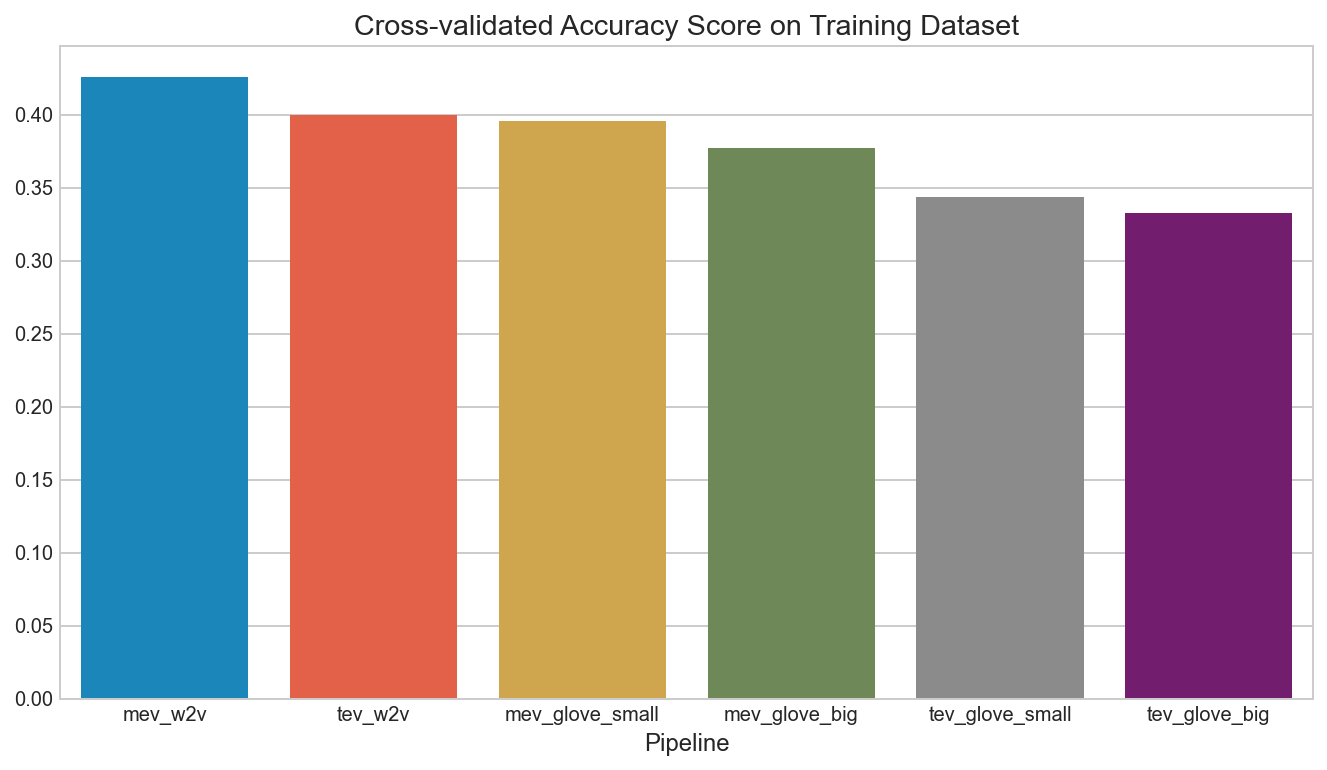

In [277]:
plt.figure(figsize=(10, 6))
sns.barplot(x=[name for name, _ in scores], y=[score for _, score in scores]);
plt.title("Cross-validated Accuracy Score on Training Dataset")
plt.xlabel("Pipeline");

<div class="alert alert-block alert-info">
As shown above, the <b>Mean Embedding Vectorizer</b> (mev) performs best together with the <b>Word2Vec</b> (w2v) word embedding based on the training dataset vocabulary, as it scores the highest in terms of the cross-validated accuracy score.<br>

We now evaluate the same set of candidate classifiers as the baseline model, to determine our best performing alternative model based on these mean Word2Vec word embeddings.
</div>

## Creation of (Inner) Training and Validation Datasets

From our single training data set (X and y) we will create two separate datasets:
- (Inner) Training Dataset: this will be used to train our models (this will take 75% of the original training dataset)
- Validation Dataset: this will be used to validate our trained models (e.g. check for overfitting) (this will take 25% of our total 'posts' dataset

To create our datasets, we use train_test_split with the stratify option to ensure a consistent mix of values for the target feature within the created datasets.

In [278]:
# Restore the original predictor and target dataframes
X = X_original.copy()
y = y_original.copy()

In [279]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=y)

In [280]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2490, 4323), (2490,), (831, 4323), (831,))

In [281]:
# Reset the indices to prevent spurious rows from appearing later during merging
X_train.reset_index(inplace=True, drop=True)
X_val.reset_index(inplace=True, drop=True)

## Generation of word embeddings

We now generate word embeddings for our text using the set of best performing word embeddings identified earlier, i.e. the Word2Vec word embeddings we created using the MeanEmbeddingVectorizer.

In [282]:
# Instantiate a Mean Embedding Vectorizer object using the Word2Vec word embeddings
mev = MeanEmbeddingVectorizer(w2v)

In [283]:
%%time
X_train_mev = mev.fit(X_train['text'], y_train)
X_train_mev = mev.transform(X_train['text'])
X_val_mev = mev.transform(X_val['text'])
X_test_mev = mev.transform(X_test['text'])

Wall time: 1min 23s


In [284]:
X_train_mev.shape, X_val_mev.shape, X_test_mev.shape

((2490, 100), (831, 100), (986, 100))

In [285]:
X_train_mev_df = pd.DataFrame(X_train_mev)
X_val_mev_df = pd.DataFrame(X_val_mev)
X_test_mev_df = pd.DataFrame(X_test_mev)

In [286]:
X_train_mev_df.shape, X_val_mev_df.shape, X_test_mev_df.shape

((2490, 100), (831, 100), (986, 100))

In [287]:
X_train_mev_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.624678,-0.914357,-0.074222,3.302932,-1.895147,0.470496,0.453211,2.386673,1.405445,-0.268042,...,-2.517390,-2.350462,1.475581,-1.264897,0.035981,-0.099127,1.753862,1.685251,0.997731,-0.449048
1,1.724697,-0.940365,-0.251819,3.256120,-1.951843,0.418448,0.425914,2.519094,1.384087,-0.298119,...,-2.602500,-2.296309,1.378060,-1.211909,0.094445,-0.172174,1.844658,1.646016,1.002514,-0.585488
2,1.692799,-0.932071,-0.164691,3.292350,-1.912947,0.419582,0.461980,2.475613,1.480590,-0.228454,...,-2.475334,-2.325155,1.502614,-1.256425,0.028187,-0.113070,1.826836,1.721111,0.950496,-0.455070
3,1.704350,-0.867250,-0.223373,3.255613,-1.910266,0.458324,0.469480,2.367508,1.377455,-0.305005,...,-2.541249,-2.284845,1.397439,-1.219277,0.082055,-0.179328,1.838062,1.641804,1.001460,-0.539933
4,1.677125,-0.908731,-0.161353,3.330494,-1.872726,0.460280,0.444671,2.411213,1.384019,-0.266639,...,-2.572756,-2.334994,1.438561,-1.204956,0.072879,-0.164187,1.789461,1.657922,0.995780,-0.496753


## Combining word embeddings with dummy columns

In [288]:
# Concatenate the components parts of the dataframe
X_train = pd.concat([X_train, X_train_mev_df], axis=1)
X_val = pd.concat([X_val, X_val_mev_df], axis=1)
X_test = pd.concat([X_test, X_test_mev_df], axis=1)

In [289]:
X_train.drop(columns=['text'], inplace=True)
X_val.drop(columns=['text'], inplace=True)
X_test.drop(columns=['text'], inplace=True)

In [290]:
X_train.shape, X_val.shape, X_test.shape

((2490, 4422), (831, 4422), (986, 4422))

In [291]:
X_train.head()

,gene_ABCB11,gene_ABCC6,gene_ABL1,gene_ACVR1,gene_ADAMTS13,gene_ADGRG1,gene_AGO2,gene_AGXT,gene_AKAP9,gene_AKT1,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,-2.517390,-2.350462,1.475581,-1.264897,0.035981,-0.099127,1.753862,1.685251,0.997731,-0.449048
1,0,0,0,0,0,0,0,0,0,0,...,-2.602500,-2.296309,1.378060,-1.211909,0.094445,-0.172174,1.844658,1.646016,1.002514,-0.585488
2,0,0,0,0,0,0,0,0,0,0,...,-2.475334,-2.325155,1.502614,-1.256425,0.028187,-0.113070,1.826836,1.721111,0.950496,-0.455070
3,0,0,0,0,0,0,0,0,0,0,...,-2.541249,-2.284845,1.397439,-1.219277,0.082055,-0.179328,1.838062,1.641804,1.001460,-0.539933
4,0,0,0,0,0,0,0,0,0,0,...,-2.572756,-2.334994,1.438561,-1.204956,0.072879,-0.164187,1.789461,1.657922,0.995780,-0.496753


In [292]:
# Save the column names for subsequent visualisation
X_train_cols = X_train.columns

## Handling of imbalanced classes

In [293]:
y_train.value_counts(normalize=True)

7    0.287149
4    0.206426
1    0.171084
2    0.136145
6    0.082731
5    0.072691
3    0.026908
9    0.011245
8    0.005622
Name: class, dtype: float64

In [294]:
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3     67
9     28
8     14
Name: class, dtype: int64

We follow the same oversampling strategy as per the baseline model -- i.e. we use ADASYN to oversample the 3 most infrequent classes to be approx. 100 samples each.

In [295]:
# Instantiate an ADASYN object to oversample minority classes
adasyn = ADASYN(random_state=42, sampling_strategy={3:100, 9:100, 8:100}, n_jobs=4)

In [296]:
%%time
X_train, y_train = adasyn.fit_sample(X_train, y_train)

Wall time: 31.3 s


In [297]:
X_train.shape, y_train.shape

((2677, 4422), (2677,))

In [298]:
# Verify that we now have 181 samples for classes '5', '3' and '8'.
y_train.value_counts()

7    715
4    514
1    426
2    339
6    206
5    181
3    101
8    100
9     95
Name: class, dtype: int64

## Scaling the data for PCA

In [299]:
ss = StandardScaler()

In [300]:
ss.fit(pd.concat([X_train, X_val])) # we fit the StandardScaler based on all our training and validation data
X_train = ss.transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

## Dimensionality reduction using PCA

We use principle component analysis (PCA) to try and reduce the dimensions (i.e. number of features) for our various datasets, to transform the original features into new "high-performing" features, reduce the dimensionality of data, and reduce/eliminate multicollinearity. We accept that while this technique may yield better metrics for our models, it makes it difficult to interpret the final set of components (i.e. features) in the model.

In [301]:
# Initialise a PCA object
# We use the default n_components value ('None') which will take the value min(n_samples, n_features) - 1
pca = PCA(random_state=42, n_components=None)

In [302]:
%%time
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

Wall time: 13.6 s


In [303]:
X_train_pca.shape, X_val_pca.shape, X_test_pca.shape

((2677, 2677), (831, 2677), (986, 2677))

We observe above that the number of features have been significantly reduced to the number samples (approx. 39% reduction).

In [304]:
features_pca = ['PC'+str(i+1) for i in range(pca.n_components_)]
X_train_pca = pd.DataFrame(X_train_pca, columns=features_pca)
X_val_pca = pd.DataFrame(X_val_pca, columns=features_pca)
X_test_pca = pd.DataFrame(X_test_pca, columns=features_pca)

In [305]:
X_train_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC2668,PC2669,PC2670,PC2671,PC2672,PC2673,PC2674,PC2675,PC2676,PC2677
0,1.557845,-1.159429,3.220542,-1.033106,-3.405926,5.045829,-0.734737,0.333843,-2.700195,-2.262939,...,2.041808e-19,-2.880555e-34,-4.882869e-19,7.006980e-20,-1.090035e-18,3.350286e-19,6.526844e-19,4.138817e-19,-4.075310e-19,7.109837e-47
1,-0.791675,-3.420908,-2.245250,-2.478866,2.177949,-2.888886,-0.051558,-2.563502,2.066055,0.527844,...,2.041808e-19,1.629746e-32,-4.882869e-19,7.006980e-20,-1.090035e-18,3.350286e-19,6.526844e-19,4.138817e-19,-4.075310e-19,1.890555e-44
2,-0.551685,4.649189,3.849763,-4.470686,-0.580903,-1.144667,-0.476515,2.169614,-1.412044,-0.549352,...,2.041808e-19,1.038839e-32,-4.882869e-19,7.006980e-20,-1.090035e-18,3.350286e-19,6.526844e-19,4.138817e-19,-4.075310e-19,2.403947e-44
3,0.862365,-0.735797,-3.323747,-2.890761,-0.224084,-2.584214,3.478236,0.122159,-0.915761,1.556334,...,2.041808e-19,-6.284889e-33,-4.882869e-19,7.006980e-20,-1.090035e-18,3.350286e-19,6.526844e-19,4.138817e-19,-4.075310e-19,-7.581465e-45
4,0.518134,-1.038984,-0.684677,-3.113772,2.859013,1.014702,0.205395,0.715442,-0.435590,0.362945,...,2.041808e-19,2.366857e-32,-4.882869e-19,7.006980e-20,-1.090035e-18,3.350286e-19,6.526844e-19,4.138817e-19,-4.075310e-19,-1.832186e-44


In [306]:
# Update the datasets for model training
X_train = X_train_pca
X_val = X_val_pca
X_test = X_test_pca

We now plot the cumulative explained variance as the number of components increase - this tells us how much information (variance) is captured by each principal component.

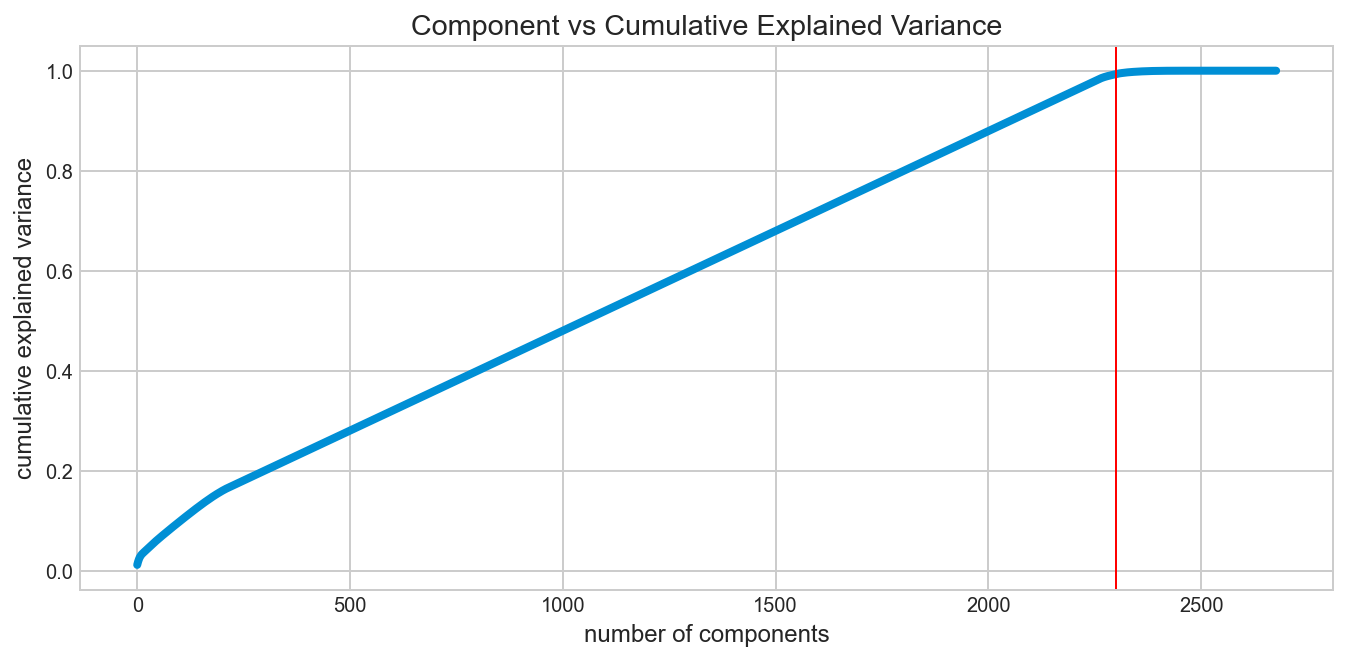

In [307]:
plt.figure(figsize=(10,5))
plt.title("Component vs Cumulative Explained Variance")
graph = sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
graph.axvline(x=2300, lw=1, color='r');

We observe from the red vertical line on the plot above that the cumulative explained variance reaches a plateau at around 2,300 principle components or so. In other words, there is hardly any significant change in variance caused after we reach 2,300 principle components.

To lessen the overfitting of our model and accelerate model fitting, we reduce the number of features to the first 1,800 principle components.

In [308]:
# Reduce the number of principle components (i.e features)
comp_limit = 2300
X_train = X_train.iloc[:,:comp_limit]
X_val = X_val.iloc[:,:comp_limit]
X_test = X_test.iloc[:,:comp_limit]

In [309]:
X_train.shape, X_val.shape, X_test.shape

((2677, 2300), (831, 2300), (986, 2300))

## Randomised search for optimal classifier parameters

To manage the total time and resources used to tune the classifier parameters, we use the RandomizedSearchCV to randomly select parameters from the specified ranges of parameters to give the best 5-fold cross-validated accuracy score on the training dataset, with a maximum of 10 iterations. We specify the range of parameters for each classifer based on experience and past results of running the RandomizedSearchCV.

We select the best classifier as the one with the highest balanced (weighted) accuracy score on the **validation dataset**.

In [310]:
def model_func(layer_one_neurons=1000, layer_one_dropout=0.2,
               layer_two_neurons=500, layer_two_dropout=0.2, opt_learning_rate=0.001):

    model = Sequential()

    model.add(Dense(layer_one_neurons, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dropout(layer_one_dropout))

    model.add(Dense(layer_two_neurons, activation='relu'))
    model.add(Dropout(layer_two_dropout))

    model.add(Dense(9,activation='softmax'))

    Ad = optimizers.Adam(learning_rate=opt_learning_rate,
                         beta_1=0.9, beta_2=0.999, amsgrad=False)
    model.compile(loss='categorical_crossentropy', optimizer=Ad,
                  metrics=['accuracy'], weighted_metrics=['accuracy'])
    return model

In [311]:
# We have selected a range of candidate classifiers
estimators = {
    'dtree': DecisionTreeClassifier(random_state=42), # Decision Tree Classifier
    'gnb': GaussianNB(), # Gaussian Naive Bayes Classifier
    'etree': ExtraTreesClassifier(random_state=42), # Extra Trees Classifier
    'knn': KNeighborsClassifier(), # K-nearest Neighbours Classifier
    'nn': KerasClassifier(build_fn=model_func, epochs=10, verbose=0), # Forward Neural Network Classifier
    'svc': SVC(random_state=42), # Support Vector Classifier
    'rf': RandomForestClassifier(random_state=42), # Random Forest Classifier
    'ada': AdaBoostClassifier(random_state=42), # ADABoost Classifier
    'lr': LogisticRegression(random_state=42) # Logistic Regression Classifier
}.items()

In [312]:
params = {
    'dtree': {
        'dtree__criterion': ['gini', 'entropy'],
        'dtree__splitter': ['best', 'random'],
        'dtree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'dtree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'dtree__max_features': ['auto', 'sqrt', 'log2', None],
        'dtree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'gnb': {
        'gnb__var_smoothing': np.logspace(-9, -1, num=20)
    },
    'etree': {
        'etree__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'etree__criterion': ['gini', 'entropy'],
        'etree__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'etree__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'etree__max_features': ['auto', 'sqrt', 'log2', None],
        'etree__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'knn': {
        'knn__n_neighbors': np.linspace(5, 20, num=10, dtype='int'),
        'knn__weights': ['uniform', 'distance'],
        'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'knn__leaf_size': np.linspace(30, 50, num=10, dtype='int'),
        'knn__p': [1, 2],
        'knn__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'nn': {
        'nn__layer_one_neurons': np.linspace(500, X_train.shape[1], num=10, dtype='int').tolist(),
        'nn__layer_one_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__layer_two_neurons' : np.linspace(200, 1000, num=10, dtype='int').tolist(),
        'nn__layer_two_dropout': np.linspace(0.1, 0.5, num=5).tolist(),
        'nn__opt_learning_rate' : np.logspace(-3, -1, num=5).tolist()
    },
    'svc': {
        'svc__C': np.logspace(-3, 3, num=10),
        'svc__gamma': ['scale', 'auto'],
        'svc__kernel': ['linear','poly', 'rbf', 'sigmoid'],
        'svc__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'rf': {
        'rf__n_estimators': np.linspace(100, 200, num=10, dtype='int'),
        'rf__criterion': ['gini', 'entropy'],
        'rf__min_samples_split': np.linspace(2, 10, num=5, dtype='int'),
        'rf__min_samples_leaf': np.linspace(1, 10, num=5, dtype='int'),
        'rf__max_features': ['auto', 'sqrt', 'log2', None],
        'rf__class_weight': ['balanced'] # 'balanced' will help to deal with our imbalanced classes
    },
    'ada': {
        'ada__n_estimators': np.linspace(50, 200, num=10, dtype='int'),
        'ada__learning_rate': np.linspace(1, 5, num=9),
        'ada__algorithm': ['SAMME', 'SAMME.R']
    },
    'lr': {
        # 'liblinear' solver has been excluded as a potential solver as it cannot learn a true multinomial
        # (multiclass) model; instead, the optimization problem is decomposed in a “one-vs-rest”
        # fashion so separate binary classifiers are trained for all classes.
        'lr__penalty': ['l1', 'l2', 'elasticnet'],
        'lr__C': np.logspace(-3, 3, num=10),
        'lr__class_weight': ['balanced'], # 'balanced' will help to deal with our imbalanced classes
        'lr__solver': ['newton-cg', 'lbfgs', 'sag','saga'], 
        'lr__multi_class': ['multinomial'],
        'lr__l1_ratio': np.linspace(0, 1, num=9),
        'lr__max_iter': [500]
    }
}

We now use RandomizedSearchCV to select the optimal parameters for each classifier that produces the best 5-fold cross-validation balanced accuracy score based on the training dataset.

In [313]:
%%time
# initialise empty lists to store information later
models = []
parameters = []
best_score = []
train_bal_f1_score = []
val_bal_f1_score = []
train_bal_accuracy = []
val_bal_accuracy = []

for k,v in estimators:
    start = time.time()
    pipe = Pipeline([(k,v)])
    param = params[k]
    randomsearch = RandomizedSearchCV(
        n_iter = 10, # we set a max. of 10 iterations
        estimator = pipe,
        random_state = 42,
        param_distributions = param,
        verbose = 1,
        cv = 5, # 5-fold cross-validation
        n_jobs=None,
        return_train_score= True,
        scoring = 'balanced_accuracy' # cater for class imbalance
    )

    now = datetime.datetime.now()
    print ("Model: ", k)
    print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
    
    randomsearch.fit(X_train, y_train)
    
    model = randomsearch.best_estimator_
    cv_score = randomsearch.cv_results_
    best_params = randomsearch.best_params_

    # predict y
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # print results
    print ("Fitting duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-start))))
    print ("Best parameters:", best_params)
    print ("Best cross-validation balanced accuracy score:", randomsearch.best_score_)
    print ("Training set balanced F1 score:", f1_score(y_train, y_train_pred, average='weighted'))
    print ("Validation set balanced F1 score:", f1_score(y_val, y_val_pred, average='weighted'))
    print ("Training set balanced accuracy:", balanced_accuracy_score(y_train,y_train_pred))
    print ("Validation set balanced accuracy:", balanced_accuracy_score(y_val,y_val_pred))
    print ("")
    
    # append info to list
    models.append(k)
    best_score.append(randomsearch.best_score_)
    parameters.append(best_params)
    train_bal_f1_score.append(f1_score(y_train,y_train_pred, average='weighted'))
    val_bal_f1_score.append(f1_score(y_val,y_val_pred, average='weighted'))
    train_bal_accuracy.append(balanced_accuracy_score(y_train,y_train_pred))
    val_bal_accuracy.append(balanced_accuracy_score(y_val,y_val_pred))

Model:  dtree
Started fitting at: 2020-04-15 17:24:37
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   10.0s finished


Fitting duration (h:m:s): 0:00:10.563936
Best parameters: {'dtree__splitter': 'best', 'dtree__min_samples_split': 8, 'dtree__min_samples_leaf': 3, 'dtree__max_features': 'sqrt', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.46488179665510077
Training set balanced F1 score: 0.8276820774338074
Validation set balanced F1 score: 0.19374810961789254
Training set balanced accuracy: 0.8867659862841492
Validation set balanced accuracy: 0.29433227515150623

Model:  gnb
Started fitting at: 2020-04-15 17:24:48
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.5min finished


Fitting duration (h:m:s): 0:02:32.855268
Best parameters: {'gnb__var_smoothing': 1.274274985703132e-07}
Best cross-validation balanced accuracy score: 0.2847827994999291
Training set balanced F1 score: 0.404052162061531
Validation set balanced F1 score: 0.034216956845299996
Training set balanced accuracy: 0.4761935116919945
Validation set balanced accuracy: 0.1230854384214943

Model:  etree
Started fitting at: 2020-04-15 17:27:21
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 24.0min finished


Fitting duration (h:m:s): 0:25:39.662956
Best parameters: {'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.6219734592873263
Training set balanced F1 score: 0.989560461610274
Validation set balanced F1 score: 0.38937867359345907
Training set balanced accuracy: 0.9925480061458676
Validation set balanced accuracy: 0.3893146817625198

Model:  knn
Started fitting at: 2020-04-15 17:53:00
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 19.1min finished


Fitting duration (h:m:s): 0:19:43.065873
Best parameters: {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 6, 'knn__metric': 'euclidean', 'knn__leaf_size': 38, 'knn__algorithm': 'ball_tree'}
Best cross-validation balanced accuracy score: 0.2817783556627792
Training set balanced F1 score: 1.0
Validation set balanced F1 score: 0.07720385615966481
Training set balanced accuracy: 1.0
Validation set balanced accuracy: 0.21488437834503488

Model:  nn
Started fitting at: 2020-04-15 18:12:44
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 29.5min finished


Fitting duration (h:m:s): 0:30:43.175436
Best parameters: {'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 2300, 'nn__layer_one_dropout': 0.30000000000000004}
Best cross-validation balanced accuracy score: 0.35121675488262916
Training set balanced F1 score: 0.9943973334212987
Validation set balanced F1 score: 0.3841139561330966
Training set balanced accuracy: 0.988512318032918
Validation set balanced accuracy: 0.3652999068556173

Model:  svc
Started fitting at: 2020-04-15 18:43:27
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 43.9min finished


Fitting duration (h:m:s): 0:45:13.992202
Best parameters: {'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__class_weight': 'balanced', 'svc__C': 215.44346900318823}
Best cross-validation balanced accuracy score: 0.35125176899561283
Training set balanced F1 score: 0.9985060258920924
Validation set balanced F1 score: 0.13108629139594974
Training set balanced accuracy: 0.9954970760233918
Validation set balanced accuracy: 0.2302121370893612

Model:  rf
Started fitting at: 2020-04-15 19:28:41
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 40.2min finished


Fitting duration (h:m:s): 0:40:57.908940
Best parameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}
Best cross-validation balanced accuracy score: 0.6173702667193831
Training set balanced F1 score: 0.9293646985179431
Validation set balanced F1 score: 0.31064256275805724
Training set balanced accuracy: 0.9443410049206248
Validation set balanced accuracy: 0.365807693484822

Model:  ada
Started fitting at: 2020-04-15 20:09:39
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 84.9min finished


Fitting duration (h:m:s): 1:26:18.092502
Best parameters: {'ada__n_estimators': 133, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}
Best cross-validation balanced accuracy score: 0.36152780317359373
Training set balanced F1 score: 0.45648516975549047
Validation set balanced F1 score: 0.3599246581331582
Training set balanced accuracy: 0.4164299157852307
Validation set balanced accuracy: 0.2670024056647552

Model:  lr
Started fitting at: 2020-04-15 21:35:57
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Deta

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linea

Fitting duration (h:m:s): 0:27:33.170458
Best parameters: {'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__max_iter': 500, 'lr__l1_ratio': 0.125, 'lr__class_weight': 'balanced', 'lr__C': 0.1}
Best cross-validation balanced accuracy score: 0.3362051758124114
Training set balanced F1 score: 0.9828842989734415
Validation set balanced F1 score: 0.44279173407550787
Training set balanced accuracy: 0.9658781552551865
Validation set balanced accuracy: 0.39690083941043114

Wall time: 4h 38min 52s


C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


## Selection of Alternative Model

In [314]:
# Produce a summary table of the tuned classifiers
summary = pd.DataFrame({
    'model': models,
    'parameters': parameters,
    'Best cross-validation balanced accuracy score': best_score,
    'Training set balanced F1 score': train_bal_f1_score,
    'Validation set balanced F1 score': val_bal_f1_score,
    'Training set balanced accuracy': train_bal_accuracy,
    'Validation set balanced accuracy': val_bal_accuracy
    })

pd.set_option('display.max_colwidth', None)
summary.sort_values('Validation set balanced accuracy', ascending=False).reset_index(drop=True)

,model,parameters,Best cross-validation balanced accuracy score,Training set balanced F1 score,Validation set balanced F1 score,Training set balanced accuracy,Validation set balanced accuracy
0,lr,"{'lr__solver': 'saga', 'lr__penalty': 'l2', 'lr__multi_class': 'multinomial', 'lr__max_iter': 500, 'lr__l1_ratio': 0.125, 'lr__class_weight': 'balanced', 'lr__C': 0.1}",0.336205,0.982884,0.442792,0.965878,0.396901
1,etree,"{'etree__n_estimators': 100, 'etree__min_samples_split': 4, 'etree__min_samples_leaf': 5, 'etree__max_features': None, 'etree__criterion': 'gini', 'etree__class_weight': 'balanced'}",0.621973,0.989560,0.389379,0.992548,0.389315
2,rf,"{'rf__n_estimators': 200, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 10, 'rf__max_features': 'sqrt', 'rf__criterion': 'entropy', 'rf__class_weight': 'balanced'}",0.617370,0.929365,0.310643,0.944341,0.365808
3,nn,"{'nn__opt_learning_rate': 0.001, 'nn__layer_two_neurons': 555, 'nn__layer_two_dropout': 0.1, 'nn__layer_one_neurons': 2300, 'nn__layer_one_dropout': 0.30000000000000004}",0.351217,0.994397,0.384114,0.988512,0.365300
4,dtree,"{'dtree__splitter': 'best', 'dtree__min_samples_split': 8, 'dtree__min_samples_leaf': 3, 'dtree__max_features': 'sqrt', 'dtree__criterion': 'entropy', 'dtree__class_weight': 'balanced'}",0.464882,0.827682,0.193748,0.886766,0.294332
5,ada,"{'ada__n_estimators': 133, 'ada__learning_rate': 1.5, 'ada__algorithm': 'SAMME'}",0.361528,0.456485,0.359925,0.416430,0.267002
6,svc,"{'svc__kernel': 'rbf', 'svc__gamma': 'auto', 'svc__class_weight': 'balanced', 'svc__C': 215.44346900318823}",0.351252,0.998506,0.131086,0.995497,0.230212
7,knn,"{'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 6, 'knn__metric': 'euclidean', 'knn__leaf_size': 38, 'knn__algorithm': 'ball_tree'}",0.281778,1.000000,0.077204,1.000000,0.214884
8,gnb,{'gnb__var_smoothing': 1.274274985703132e-07},0.284783,0.404052,0.034217,0.476194,0.123085


Based on the table above, we observe the following:
- The best performing model is the multinomial Logistic Regression Clasifier with a validation dataset balanced accuracy score of `0.396901` which is just barely more than 10% better than our baseline accuracy score of `0.286962`. It also has a balanced F1 score of `0.442792`.
- For all the models, the balanced F1 and accuracy scores for the validation dataset are lower that the respective scores on the training dataset -- this indicates that all our models tend to be overfitted.

<div class="alert alert-block alert-info">
We consider our alternative model to be the <b>Logistic Regression Clasifier</b> with the parameters shown above, trained on <b>Word2Vec word embeddings</b> using the <b>Mean Embedding Vectorizer</b>.
</div>

## Further Exploration of Alternative Model

To further explore this classifier, we first instantiate the baseline classifier based on the best parameters found above, and then fit it on the validation dataset.

In [337]:
# We instantiate the alternative classifier based on the best parameters found above
alternative_clf = LogisticRegression(verbose=1, n_jobs=4, random_state=42, solver='saga', penalty='l2',
                                  multi_class='multinomial', l1_ratio=0.125,
                                  class_weight='balanced', C=0.1)

In [338]:
%%time
# Fit the best classifier on the validation dataset
alternative_clf.fit(X_val, y_val)

C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:1501: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty))
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 7 seconds
Wall time: 6.56 s


C:\Users\yuchy\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    6.4s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.125,
                   max_iter=100, multi_class='multinomial', n_jobs=4,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=1, warm_start=False)

### Logistic Regression Coefficients

We now print out the top 5 principle components and their coefficients, for each of the 9 classes. A one-unit change in each principle component means that the prediction for the respective class is $e^{c}$ times as likely, where c is the coefficient value shown.

In [339]:
for cl in range(0,9):
    scores = pd.DataFrame(alternative_clf.coef_, columns=X_train.columns)
    print("\n---------------------------------------------------------------------------")
    print("Top 5 principle components and coefficient values for prediction of class {}".format(cl+1))
    print("---------------------------------------------------------------------------")
    print(np.exp(scores.loc[cl,np.exp(scores.loc[cl,:].sort_values(ascending=False)).head(5).index.tolist()]))


---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 1
---------------------------------------------------------------------------
PC2278    1.224259
PC2272    1.148605
PC196     1.140537
PC12      1.136099
PC135     1.107927
Name: 0, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 2
---------------------------------------------------------------------------
PC5       1.257354
PC2       1.144000
PC167     1.108392
PC93      1.107726
PC2284    1.102121
Name: 1, dtype: float64

---------------------------------------------------------------------------
Top 5 principle components and coefficient values for prediction of class 3
---------------------------------------------------------------------------
PC7      1.254580
PC14     1.187430
PC63     1.154627
PC186    1.148867
PC6

As expected:
1. The top 5 principle components for each class are mostly different from one another. This is a direct consequence of performing PCA - we obtain principle components which are mostly independent of one another.
2. It is not straightforward to interpret what each principle component means, in relation to the set of the features in the original datasets prior to performing PCA. In other words, we cannot easily identify what set of word(s) each principle component refers to. We accept this, as we have benefitted from faster model training times; our problem statement is focused on coming up with a classifier, and not to understand what words/phrases are key to predicting which classes.

### ROC curves and metrics for Validation Dataset

In [341]:
# Generate predictions for the validation data based on our alternative model
y_val_pred = alternative_clf.predict(X_val)

In [342]:
# Binarize the output
y_train_binarized = label_binarize(y_train, classes=list(np.unique(y)))
y_val_pred_binarized = label_binarize(y_val_pred, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

To come up with actual scores that can be used for ROC calculation, we use the OneVsRestClassifier coupled with a SVC (C-Support Vector) Classifier to fit the training dataset so that we can obtain the distances of each sample from the decision boundary for each class.

In [343]:
%%time
now = datetime.datetime.now()
print ("Started fitting at: {}".format(now.strftime("%Y-%m-%d %H:%M:%S")))
# We obtain the distances of each sample from the decision boundary for each class
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=42, verbose=1), n_jobs=2)
y_score = classifier.fit(X_train, y_train_binarized).decision_function(X_val)

Started fitting at: 2020-04-15 22:49:01
Wall time: 5min 23s


In [344]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    # we compare our predicted labels for the validation dataset and the actual validation dataset labels
    fpr[i], tpr[i], _ = roc_curve(y_val_pred_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_pred_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

We plot ROC curves for all the 9 classes.

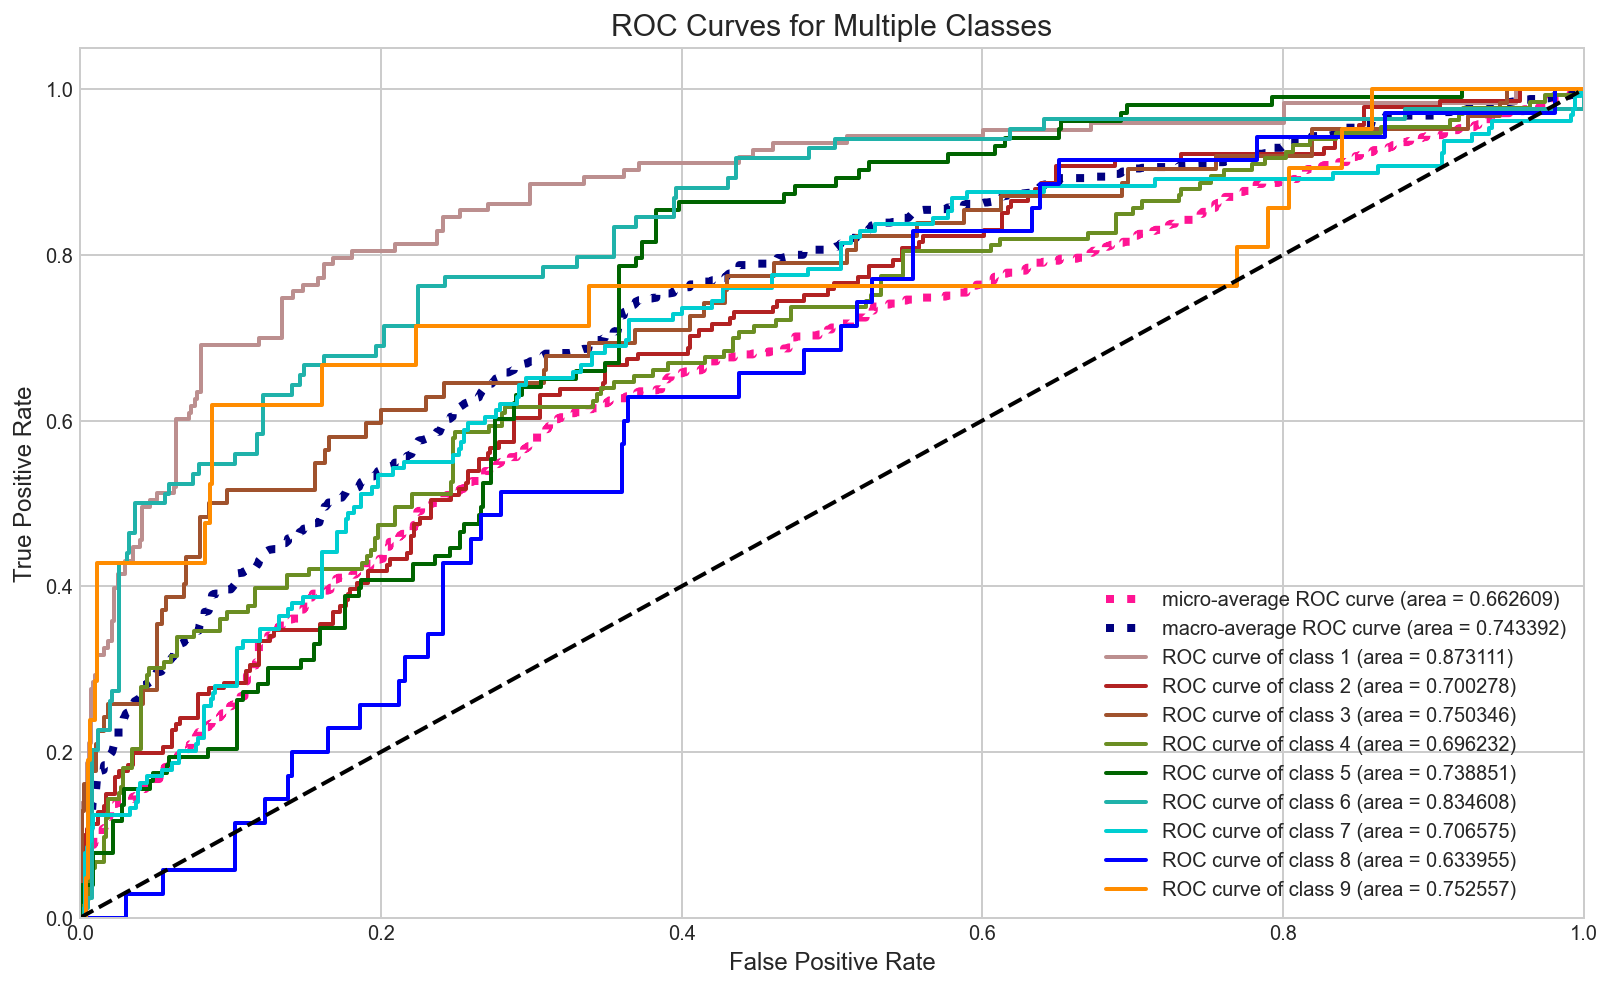

In [345]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.6f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

lw=2
colors = cycle(['rosybrown', 'firebrick', 'sienna', 'olivedrab', 'darkgreen',\
                'lightseagreen', 'darkturquoise', 'b', 'darkorange'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.6f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Classes', fontsize=15)
plt.legend(loc="lower right")
plt.show()

We note from the ROC curves and AUC scores ('area' metric) in the plot above that the micro-average AUC score is `0.662609` which is lower than the corresponding score of `0.759990` for the baseline model.

### Confusion Matrix

We plot a confusion matrix can be used to evaluate the quality of the output of our classifier.

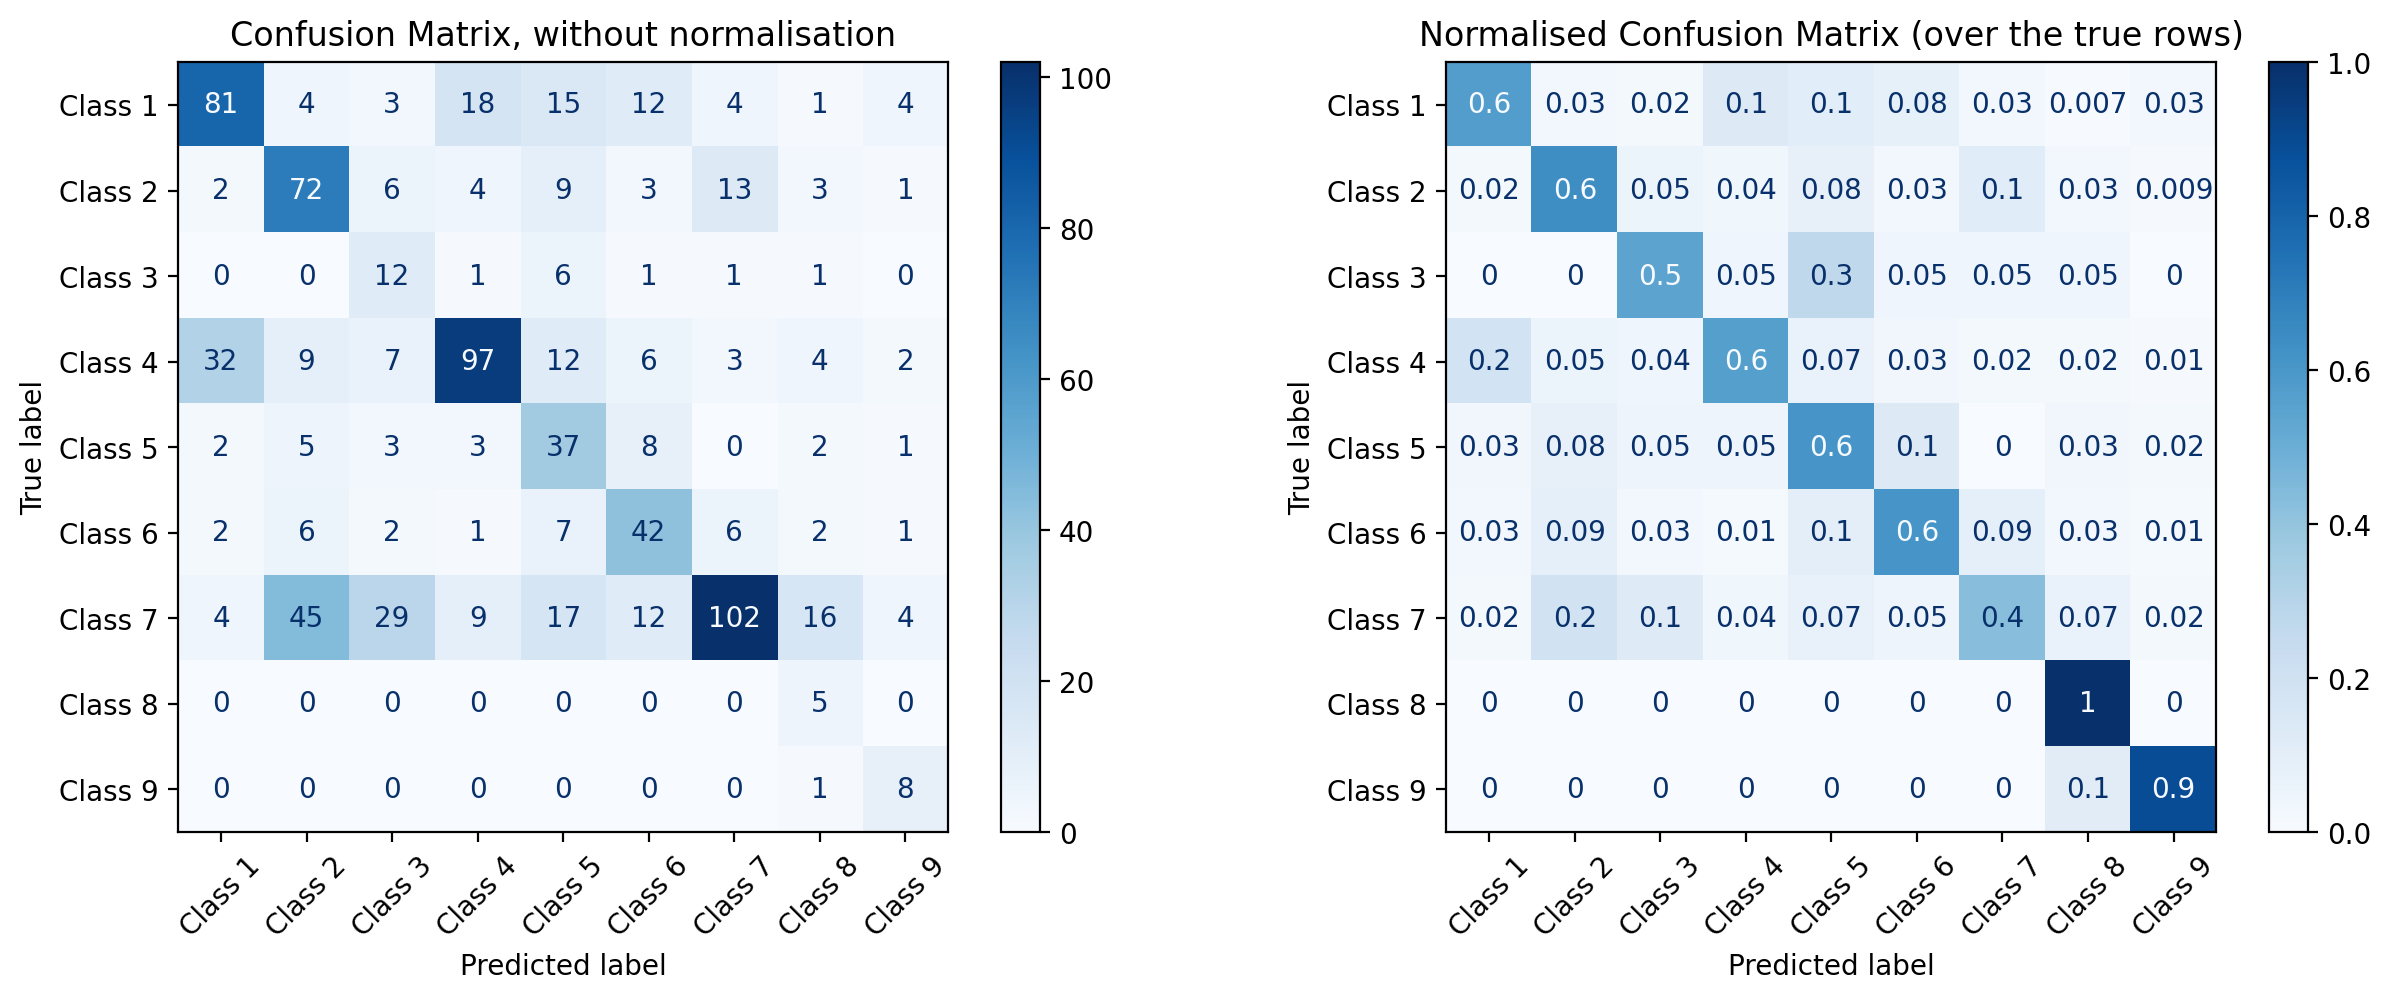

In [347]:
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
disp = plot_confusion_matrix(alternative_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.4g', xticks_rotation=45,
                             normalize=None, ax=ax1)
disp = plot_confusion_matrix(alternative_clf, X_val, y_val,
                             display_labels=['Class '+str(i+1) for i in range(0,9)],
                             cmap=plt.cm.Blues, values_format='.1g', xticks_rotation=45,
                             normalize='true', ax=ax2)
ax1.set_title("Confusion Matrix, without normalisation")
ax2.set_title("Normalised Confusion Matrix (over the true rows)")
plt.show();  

As shown above, the diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions. In particular the ideal diagonal values for the normalised confusion matrix are 1.

For the normalised confusion matrix, we note from the values in the diagonal that only the predictions for Classes 8 and 9 are relatively correct (>=0.9).

### Comparison of Frequency Distributions

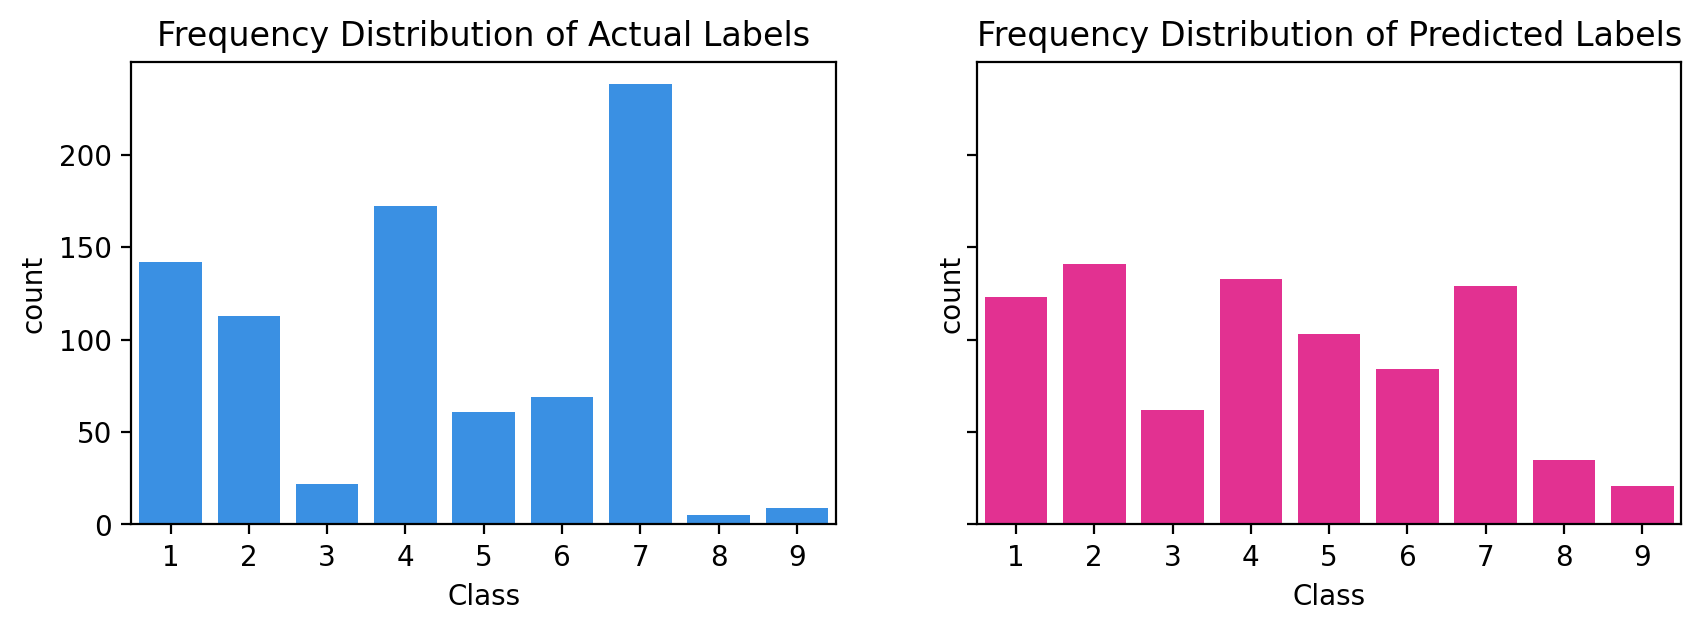

In [348]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.countplot(y_val, color="dodgerblue", ax=axes[0])
sns.countplot(y_val_pred, color="deeppink", ax=axes[1]);
axes[0].set_title("Frequency Distribution of Actual Labels")
axes[1].set_title("Frequency Distribution of Predicted Labels")
axes[0].set_xlabel("Class")
axes[1].set_xlabel("Class");

A comparison of the two frequency distributions shows that the relative frequencies of the classes have not been well preserved in the predictions. In particular our alternative model has failed to make more predictions of classes 4 and 7.

## Selection of Final Model

The use of the Word2Vec and GloVe word embeddings has not resulted in any improvements over the baseline model. In fact variance has increased as a result, and the alternative model is more overfitted compared to the baseline model, based on a comparison of the balanced accuracy, balanced F1 and micro-average AUC scores. Further visual evidence of this can be seen in the ROC curves, confusion matrix and histogram plots above. In summary, we obtained the following scores:

|Metric|Baseline Model<br>(Logistic Regression with<br>Tfidf word weights)|Alternative Model<br>(Logistic Regression using<br>mean Word2Vec embeddings)|
|:--|---|---|
|Balanced Accuracy Score|0.540169|0.396901|
|Balanced F1 Score|0.618036|0.442792|
|Micro-average AUC score|0.759990|0.662609|

We therefore choose the baseline model as our final model -- i.e. the multinomial <b>Logistic Regression Classifier</b> trained on <b>TfidfVectorizer</b> weighted word frequencies. It meets our success criteria of exceeding the baseline accuracy of `0.286962` by at least 10%. The full parameters of the Logistic Regression Classifier are shown below.

```
LogisticRegression(C=215.44346900318823, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0,
                   max_iter=100, multi_class='multinomial', n_jobs=4,
                   penalty='l2', random_state=42, solver='saga', tol=0.0001,
                   verbose=1, warm_start=False)
```

## Data Export (for Kaggle Submission)

For completeness, we export the predictions from the alternative model for Kaggle submission in Notebook 5.

In [330]:
y_test_pred = seq_model.predict_classes(X_test)
y_test_pred += 1 # Adjust the predictions since the raw predictions are from 0 to 8

In [331]:
y_test_pred.shape

(986,)

In [332]:
# Restore the 'id' column since we need this for the Kaggle submission
test_pred = pd.concat([test['id'], pd.DataFrame(y_test_pred, columns=['class'])], axis=1)

In [333]:
# Verify that we have a mix of predictions for variation classes
test_pred['class'].value_counts()

1    253
7    233
2    171
4    101
8     96
9     60
5     37
6     27
3      8
Name: class, dtype: int64

In [334]:
test_pred.head()

,id,class
0,1,8
1,2,1
2,3,7
3,4,1
4,5,7


In [335]:
# We export the predictions
test_pred.to_csv("../assets/test_pred.csv", index=False)

---

In [336]:
# For tracking the execution time for the entire notebook
print ("Notebook execution duration (h:m:s): {}".format(str(datetime.timedelta(seconds=time.time()-notebook_start))))

Notebook execution duration (h:m:s): 5:00:57.712680
